# 라이브러리 임포트 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import transforms

# CUDA 설정

In [ ]:
if torch.cuda.is_available():
    cuda = torch.device('cuda')
else:
    cuda = torch.device('cpu')

print(cuda)

cuda


In [ ]:
torch.manual_seed(777)

# 데이터 로드

In [ ]:
train_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.1307, std=0.3081),
])

test_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.1307, std=0.3081)
])

In [ ]:
train_data = MNIST(root='./data', download=True, train=True, transform=train_trans)
test_data = MNIST(root='./data', download=True, train=False, transform=test_trans)

In [ ]:
batch_size = 128
train_load = DataLoader(train_data, batch_size, num_workers=2, shuffle=True)
test_load = DataLoader(test_data, batch_size, num_workers=2, shuffle=True)

# GRU Cell을 이용한 RNN 구현

## single_gru

In [ ]:
# GRUCell 구현
class RNN(nn.Module):
    def __init__(self, input_size, sequence_length ,hidden_size, layer_size, num_class, batch_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.layer = layer_size
        self.num_class = num_class

        self.seq = sequence_length
        self.gru = nn.GRUCell(self.input_size, self.hidden_size*2)
        self.fc = nn.Linear(self.hidden_size*2, self.num_class)
      
        
    def forward(self, x, test=False, label=None):
        if test == False:
            hx = torch.zeros(self.layer, x.size(0), self.hidden_size*2).to('cuda')

            hx = hx[0,:,:] # 차원을 줄이기 위해 사용
            out = []
            for i in range(self.seq):
                hx = self.gru(x[:, i ,:], hx) # 입력 size = > (batch_size, input_size) hx = > (batch_size, hidden_size)
                out.append(hx)

            out = self.fc(out[-1])

            return out
        else:
            hx = torch.zeros(self.layer, x.size(0), self.hidden_size*2).to('cuda')
            hx = hx[0,:,:] # 차원을 줄이기 위해 사용
            for i in range(self.seq):
                hx = self.gru(x[:, i ,:], hx) # 입력 size = > (batch_size, input_size) hx = > (batch_size, hidden_size)
                out = self.fc(hx)
                pred = out.max(1, keepdim=True)[1]
                acc = pred.eq(label.view_as(pred)).sum().item()
                if acc == self.batch_size:
                    #print(f'time step {i}')
                    return out
            
            return out
                
                
        

## multi_gru

In [ ]:
# GRUCell 구현
class Multi_RNN(nn.Module):
    def __init__(self, input_size, sequence_length ,hidden_size, layer_size, num_class, batch_size):
        super(Multi_RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.layer = layer_size
        self.num_class = num_class
        self.batch_size = batch_size
        self.seq = sequence_length
        self.gru1 = nn.GRUCell(self.input_size, self.hidden_size)
        self.gru2 = nn.GRUCell(self.hidden_size, self.hidden_size*2)
        self.gru3 = nn.GRUCell(self.hidden_size*2, self.hidden_size*4)
        self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Linear(self.hidden_size*4, self.num_class)
        
        
    def forward(self, x, test=False, label=None):
        if test == False:
            hx1 = torch.zeros(x.size(0), self.hidden_size).to('cuda')
            hx2 = torch.zeros(x.size(0), self.hidden_size*2).to('cuda')
            hx3 = torch.zeros(x.size(0), self.hidden_size*4).to('cuda')
            out = []
            for i in range(self.seq):
                hx1 = self.gru1(x[:, i ,:], hx1) # 입력 size = > (batch_size, input_size) hx = > (batch_size, hidden_size)
                hx1 = self.dropout(hx1)
                hx2 = self.gru2(hx1, hx2)
                hx2 = self.dropout(hx2)
                hx3 = self.gru3(hx2, hx3)
                
                out.append(hx3)

            out = self.fc(out[-1])

            return out
        else:
            hx1 = torch.zeros(x.size(0), self.hidden_size).to('cuda')
            hx2 = torch.zeros(x.size(0), self.hidden_size*2).to('cuda')
            hx3 = torch.zeros(x.size(0), self.hidden_size*4).to('cuda')
            out = []
            for i in range(self.seq):
                hx1 = self.gru1(x[:, i ,:], hx1) # 입력 size = > (batch_size, input_size) hx = > (batch_size, hidden_size)
                hx2 = self.gru2(hx1, hx2)
                hx3 = self.gru3(hx2, hx3)
                out = self.fc(hx3)
                pred = out.max(1, keepdim=True)[1]
                acc = pred.eq(label.view_as(pred)).sum().item()
                if acc == self.batch_size:
                    #print(f'time step {i}')
                    return out
            
            return out
                

# 학습 설정 및 모델 객체화

In [ ]:
sequence_length = 28
input_size = 28
hidden_size = 128

num_classes = 10

model = RNN(input_size, sequence_length, hidden_size, num_layers, num_classes, batch_size)

# 모델 학습 및 평가

In [ ]:
# 평가 함수
def evaluate(model, test_loader):
    model.eval()
    
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, label = sample
            data = data.reshape(-1, 28, 28)
            data = data.to(cuda)
            label = label.to(cuda)

            output = model(data, True, label)
            loss = criterion(output,label)
            val_loss += loss.item()

            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

        val_loss /= len(test_loader.dataset)
        val_acc = (100. * correct) / len(test_loader.dataset)


    return val_loss, val_acc

In [ ]:
opt = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.001)

# 미분값이 0에 가까워질수록 학습률을 줄여주기 위해 사용한다. lr에 감마값을 곱해준다.

scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size = 10, gamma = 0.8) 
criterion = nn.CrossEntropyLoss().to(cuda)
model = model.to(cuda)
train_acc = []
train_loss = []

test_acc = []
test_loss = []

for epoch in range(50):
    model.train()

    accuracy = 0
    loss_ = 0
    
    loss_test = 0
    accuracy_test = 0

    for batch, train in enumerate(train_load):
        data, label = train

        data = data.reshape(-1, 28, 28)
        data = data.to(cuda)
        label = label.to(cuda)

        out = model(data)

        loss = criterion(out, label)

        loss_ += loss.item()

        pred = out.max(1, keepdim=True)[1]

        acc = pred.eq(label.view_as(pred)).sum().item()

        accuracy += acc

        opt.zero_grad()
        loss.backward()
        opt.step()

        
    epoch_loss = loss_ / len(train_load.dataset)
    epoch_acc = (100.*accuracy) / len(train_load.dataset)
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    print(f'epoch : {epoch+1}\t Loss : {epoch_loss:.6f}\t Acc : {epoch_acc}')
    loss_test, accuracy_test = evaluate(model, test_load)
    test_loss.append(loss_test)
    test_acc.append(accuracy_test)
    
    print(loss_test, accuracy_test)

    scheduler.step()


epoch : 1	 Loss : 0.006460	 Acc : 71.205
0.00261277726739645 89.56
epoch : 2	 Loss : 0.001987	 Acc : 92.355
0.0013211830578744412 94.78
epoch : 3	 Loss : 0.001182	 Acc : 95.56666666666666
0.0008250142117962241 96.83
epoch : 4	 Loss : 0.000838	 Acc : 96.90166666666667
0.0007529868412762881 97.24
epoch : 5	 Loss : 0.000692	 Acc : 97.34333333333333
0.0005943833074532449 97.7
epoch : 6	 Loss : 0.000575	 Acc : 97.875
0.0005340178694576025 97.96
epoch : 7	 Loss : 0.000481	 Acc : 98.22666666666667
0.0004551753137260675 98.23
epoch : 8	 Loss : 0.000449	 Acc : 98.30333333333333
0.0005164464157540351 98.05
epoch : 9	 Loss : 0.000392	 Acc : 98.485
0.0004784300486091524 98.31
epoch : 10	 Loss : 0.000334	 Acc : 98.69833333333334
0.0004857259118463844 98.33
epoch : 11	 Loss : 0.000294	 Acc : 98.87166666666667
0.00037787168599897995 98.65
epoch : 12	 Loss : 0.000255	 Acc : 98.99333333333334
0.00042012152737006545 98.78
epoch : 13	 Loss : 0.000237	 Acc : 99.10166666666667
0.0003664981432259083 98.65
e

In [ ]:
print(evaluate(model, test_load))

(0.0005253338096883453, 98.99)


# GRU 구현

In [ ]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, num_class):
        super(RNN2, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.layer = layer_size
        self.num_class = num_class
        
        self.gru = nn.GRU(input_size, self.hidden_size*2, self.layer, batch_first=True)
        #self.fc = nn.Linear(self.hidden_size, self.num_class)
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size*2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        hx = torch.zeros(self.layer, x.size(0), self.hidden_size*2).to('cuda')
        out, _ = self.gru(x, hx)
        out = self.fc(out[:, -1, :])
    
        return out

# 학습 설정 및 모델 객체화

In [ ]:
input_size = 28
hidden_size = 128
num_layers = 1
num_classes = 10

model = RNN2(input_size, hidden_size, num_layers, num_classes)

# 모델 학습 및 평가

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            data, label = sample
            data = data.reshape(-1, 28, 28)
            data = data.to(cuda)
            label = label.to(cuda)

            output = model(data)
            loss = criterion(output,label)
            val_loss += loss.item()

            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

        val_loss /= len(test_loader.dataset)
        val_acc = (100. * correct) / len(test_loader.dataset)


    return val_loss, val_acc

In [ ]:
opt = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.001)

# 미분값이 0에 가까워질수록 학습률을 줄여주기 위해 사용한다. lr에 감마값을 곱해준다.

scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size = 10, gamma = 0.8) 
criterion = nn.CrossEntropyLoss().to(cuda)
model = model.to(cuda)
train_acc = []
train_loss = []

test_acc = []
test_loss = []

for epoch in range(50):
    model.train()

    accuracy = 0
    loss_ = 0
    
    loss_test = 0
    accuracy_test = 0

    for batch, train in enumerate(train_load):
        data, label = train

        data = data.reshape(-1, 28, 28)
        data = data.to(cuda)
        label = label.to(cuda)

        out = model(data)

        loss = criterion(out, label)

        loss_ += loss.item()

        pred = out.max(1, keepdim=True)[1]

        acc = pred.eq(label.view_as(pred)).sum().item()

        accuracy += acc

        opt.zero_grad()
        loss.backward()
        opt.step()

        
    epoch_loss = loss_ / len(train_load.dataset)
    epoch_acc = (100.*accuracy) / len(train_load.dataset)
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    print(f'epoch : {epoch+1}\t Loss : {epoch_loss:.6f}\t Acc : {epoch_acc}')
    loss_test, accuracy_test = evaluate(model, test_load)
    test_loss.append(loss_test)
    test_acc.append(accuracy_test)
    
    print(loss_test, accuracy_test)

    scheduler.step()


epoch : 1	 Loss : 0.006663	 Acc : 70.40666666666667
0.0024453244104981424 90.91
epoch : 2	 Loss : 0.001954	 Acc : 92.89166666666667
0.0012103027317672968 95.1
epoch : 3	 Loss : 0.001088	 Acc : 96.085
0.0007962903561070561 96.98
epoch : 4	 Loss : 0.000762	 Acc : 97.275
0.0005699967806227505 97.78
epoch : 5	 Loss : 0.000600	 Acc : 97.885
0.0006052789299050346 98.04
epoch : 6	 Loss : 0.000489	 Acc : 98.23666666666666
0.0005076343753607944 98.35
epoch : 7	 Loss : 0.000420	 Acc : 98.52666666666667
0.0005031658638035879 98.25
epoch : 8	 Loss : 0.000375	 Acc : 98.66
0.0004693086785962805 98.19
epoch : 9	 Loss : 0.000329	 Acc : 98.79333333333334
0.0004163190145744011 98.51
epoch : 10	 Loss : 0.000289	 Acc : 99.015
0.00036647669021040204 98.83
epoch : 11	 Loss : 0.000225	 Acc : 99.21666666666667
0.00036139820822281765 98.79
epoch : 12	 Loss : 0.000209	 Acc : 99.235
0.000394527717854362 98.73
epoch : 13	 Loss : 0.000185	 Acc : 99.305
0.0003511115780798718 98.81
epoch : 14	 Loss : 0.000174	 Acc :

In [ ]:
print(evaluate(model, test_load))

(0.0004357078284192916, 99.19)


# 학습과정 시각화

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

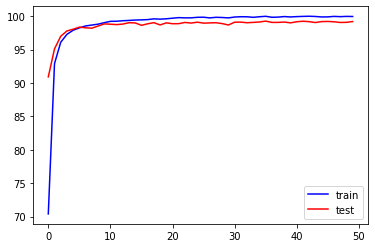

In [ ]:
plt.plot(train_acc, 'b', label='train')
plt.plot(test_acc, 'r', label='test')
plt.legend()
plt.show()

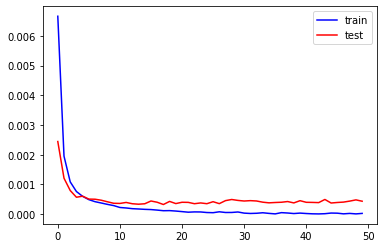

In [ ]:
plt.plot(train_loss, 'b', label='train')
plt.plot(test_loss, 'r', label='test')
plt.legend()
plt.show()